
#  Optimización del sistema Encicla en Medellín
* Felipe Miranda Arboleda
* Emilio Porras Mejía

## Modelo inicial y obtención de datos

In [1]:
%pip install folium pandas googlemaps pulp numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 1.0 MB/s eta 0:00:001.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.5 MB/s eta 0:00:00m eta 0:00:01
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached charset_normalizer-3.4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.7.14-py3-none-any.whl.metadata (2.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 1

In [2]:
import folium
import pandas as pd
import googlemaps
from time import sleep
from math import radians, sin, cos, sqrt, atan2
import numpy as np
import pulp

In [6]:


# Cargar el archivo CSV
df = pd.read_csv('Estaciones_EnCicla_AMVA_20250713.csv', header=None)

# Dividir la primera columna en múltiples columnas usando comas
split_columns = df[0].str.split(',', expand=True)

# Extraer latitud y longitud
df['Latitude'] = split_columns.iloc[:, -1]
df['Longitude'] = df[1]

# Eliminar las columnas originales
df = df.drop(columns=[0, 1])

# Renombrar las columnas
df.columns = df.iloc[0]
df = df[1:]
df.reset_index(drop=True, inplace=True)



print(df.head())

0               DIRECCION                                    Ayuda Ubicación  \
0       CALLE 82A # 52-29  Frente a la entrada principal del Centro de De...   
1         CALLE 73 # 52-2  Bajo el viaducto de la estación Universidad de...   
2     CARRERA 52 # 67A-13  Frente a la fachada principal de Ruta N sobre ...   
3  CARRERA 77A # 63 - 100             Diagonal al Colegio Mayor de Antioquia   
4    CALLE 59A # 64C - 44  Portería de la Iguaná con Carrera 65 de la Uni...   

0               MUNICIPIO    TIPO TOTAL ANCLAJES  Georeferenciación  #  \
0    Zona 1 - Nororiental  MANUAL             15   6,27658;-75,5648  1   
1    Zona 1 - Nororiental  MANUAL             33  6,26939;-75,56577  2   
2    Zona 1 - Nororiental  AUTOM.             40  6,26518;-75,56634  3   
3  Zona 2 - Noroccidental  MANUAL             21  6,27197;-75,59131  4   
4  Zona 2 - Noroccidental  MANUAL             33    6,25971;-75,579  5   

0  NOMBRE ESTACION  
0          Moravia  
1      Universidad  
2          

In [7]:

df[['Latitude', 'Longitude']] = df['Georeferenciación'].str.split(';', expand=True)


df['Latitude'] = df['Latitude'].str.replace(',', '.').astype(float)
df['Longitude'] = df['Longitude'].str.replace(',', '.').astype(float)

print(df[['Latitude', 'Longitude']].head())

0  Latitude  Longitude
0   6.27658  -75.56480
1   6.26939  -75.56577
2   6.26518  -75.56634
3   6.27197  -75.59131
4   6.25971  -75.57900


In [9]:

# Crear un mapa base centrado en Medellín
medellin_map = folium.Map(location=[6.2442, -75.5812], zoom_start=12)

# Agregar marcadores para cada estación
for _, row in df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=row['NOMBRE ESTACION']  # La columna 'NOMBRE ESTACION' contiene los nombres de las estaciones
    ).add_to(medellin_map)

# Guardar el mapa en un archivo HTML
medellin_map.save('medellin_map.html')

# Mostrar el mapa en el notebook
medellin_map

Primero se intentó con Harvesine, pero es inexacto

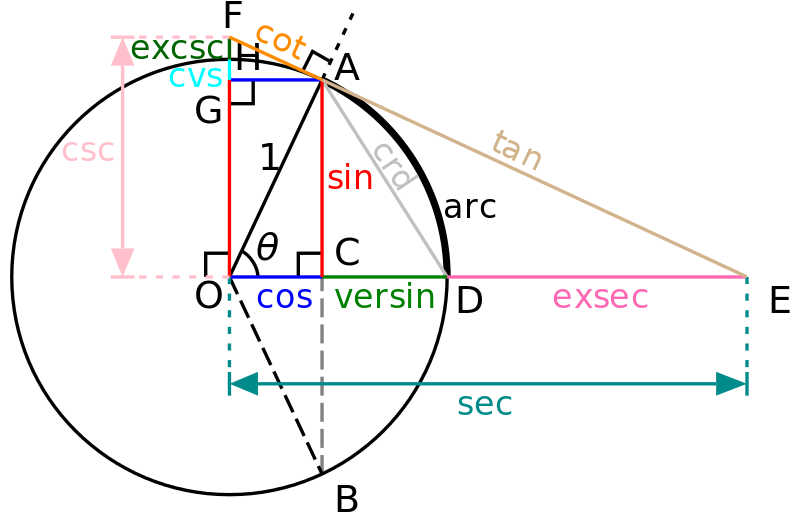

$d = 2r \cdot \arcsin\left( \sqrt{ \sin^2\left( \frac{\Delta \varphi}{2} \right) + \cos(\varphi_1) \cdot \cos(\varphi_2) \cdot \sin^2\left( \frac{\Delta \lambda}{2} \right) } \right)$


$\varphi_1$: latitud del primer punto, en radianes.

$\varphi_2$: latitud del segundo punto, en radianes.

$\Delta \varphi = \varphi_2 - \varphi_1$: diferencia de latitudes, en radianes.

$\lambda_1$: longitud del primer punto, en radianes.

$\lambda_2$: longitud del segundo punto, en radianes.

$\Delta \lambda = \lambda_2 - \lambda_1$: diferencia de longitudes, en radianes.

$r$: radio de la Tierra (promedio: $6,371$ km).

$d$: distancia entre los dos puntos a lo largo de la superficie de la esfera.


In [ ]:

def haversine(lat1, lon1, lat2, lon2):
    # Convertir latitud y longitud de grados a radianes
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Fórmula de Haversine
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    radius = 6371  # Radio de la Tierra en kilómetros
    return radius * c  # Retorna la distancia en kilómetros

# Generar la matriz de distancias
num_locations = len(df)
distance_matrix = np.zeros((num_locations, num_locations))

for i in range(num_locations):
    for j in range(num_locations):
        distance_matrix[i, j] = haversine(df.iloc[i]['Latitude'], df.iloc[i]['Longitude'],
                                          df.iloc[j]['Latitude'], df.iloc[j]['Longitude'])

# Convertir la matriz de distancias a un DataFrame para mejor legibilidad
distance_df = pd.DataFrame(distance_matrix, columns=df['NOMBRE ESTACION'], index=df['NOMBRE ESTACION'])

print(distance_df.head())

NOMBRE ESTACION   Moravia  Universidad    Ruta N   Robledo  Campus Nacional  \
NOMBRE ESTACION                                                               
Moravia          0.000000     0.806648  1.278999  2.974622         2.445867   
Universidad      0.806648     0.000000  0.472351  2.837467         1.815753   
Ruta N           1.278999     0.472351  0.000000  2.861345         1.525801   
Robledo          2.974622     2.837467  2.861345  0.000000         1.926077   
Campus Nacional  2.445867     1.815753  1.525801  1.926077         0.000000   

NOMBRE ESTACION  Dian Alpujarra  Distrito Creativo  Plaza de La Libertad  \
NOMBRE ESTACION                                                            
Moravia                3.784073           4.733480              3.840337   
Universidad            2.981270           3.927417              3.045773   
Ruta N                 2.512285           3.455524              2.583924   
Robledo                3.813567           4.672503              3.

De la siguiente manera se puede obtener con Directions API datos de un viaje en bicicleta con el problema que 1000 llamados cuestan 5 dólares, por lo que se se utiliza otra API que no sea de costo para poder llevar a cabo esta obtención de datos

## Obtención de los datos

In [ ]:
import requests
%pip install dotenv
import dotenv

dotenv.load_dotenv()

import os
API_KEY = os.getenv("API_KEY")

origin_coords = "41.43206,-81.38992"
destination_coords = "40.758896,-73.985130"

url = f"https://maps.googleapis.com/maps/api/directions/json?origin={origin_coords}&destination={destination_coords}&key={API_KEY}&mode=bicycling"

headers = {
    'Content-Type': 'application/json',
    'X-Goog-Api-Key': API_KEY,
    'X-Goog-FieldMask': 'routes.duration,routes.distanceMeters',
}

response = requests.post(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    route = data['routes'][0]
    legs = route['legs'][0]
    distance = legs.get('distance').get('value')
    duration = legs.get('duration').get('value')
    
    print(f"Distance: {distance} meters")
    print(f"Duration: {duration}")
else:
    print(f"Error {response.status_code}: {response.text}")

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Schrodiszkiwex\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


{'bounds': {'northeast': {'lat': 41.4670364, 'lng': -73.9853361}, 'southwest': {'lat': 40.4402661, 'lng': -81.3897994}}, 'copyrights': 'Powered by Google, ©2025 Google', 'legs': [{'distance': {'text': '543 mi', 'value': 874590}, 'duration': {'text': '2 days 1 hour', 'value': 176897}, 'end_address': '1556 Broadway, New York, NY 10120, USA', 'end_location': {'lat': 40.7589427, 'lng': -73.9853361}, 'start_address': '45 Bell St, Chagrin Falls, OH 44022, USA', 'start_location': {'lat': 41.4318474, 'lng': -81.3897994}, 'steps': [{'distance': {'text': '7.4 mi', 'value': 11856}, 'duration': {'text': '41 mins', 'value': 2455}, 'end_location': {'lat': 41.4329532, 'lng': -81.2481689}, 'html_instructions': 'Head <b>northeast</b> on <b>Bell St</b> toward <b>Vincent St</b>', 'polyline': {'points': 'ad{{FfmwoNKg@Kg@I_@G]CQK{@Ae@I_CEyACgAAWAa@?QEkAC]CYAOKeAIo@M_BAO?K?E?Q@M@IBMDYDS^uBXyABQBKNw@X{AF_@DQDQ?E@CBQ@A?C@A?CBI@MBUBk@AYAq@?Q?I?Q?C?E?E?CAS?G?uA?[?KAy@?qAAaB?wAA}@AmB?WAuBAgDAgA?cA?Y?M?I@_@?ABy@@

Se observa que la API de Google nos daría la distancia y la duración, sin embargo, la API utilizada únicamente nos brinda la distancia y debemos calcular por otros medios la duración

In [1]:
import requests

def get_directions(api_url, lat1, lon1, lat2, lon2, mode='bike'):
    params = {
        'lat1': lat1,
        'lon1': lon1,
        'lat2': lat2,
        'lon2': lon2,
        'mode': mode
    }
    response = requests.get(api_url, params=params)
    return response.json()['distance']

# Example usage:
result = get_directions(
    "https://www.mappedometer.com/mputil/mpDirections2.php",
    6.260778, -75.591135, 6.273027925448592, -75.56516647338869
)
print(result)


4499


Obtención de datos final en el bloque sguiente, únicamente correr si no se cuenta con distance_api_matrix.csv

In [ ]:

# Crear una nueva matriz de distancias usando get_directions solo para la parte superior de la matriz
distance_api_matrix = np.zeros((num_locations, num_locations))

for i in range(num_locations):
    for j in range(i + 1, num_locations):
        lat1, lon1 = df.iloc[i]['Latitude'], df.iloc[i]['Longitude']
        lat2, lon2 = df.iloc[j]['Latitude'], df.iloc[j]['Longitude']
        try:
            distance = get_directions(
                "https://www.mappedometer.com/mputil/mpDirections2.php",
                lat1, lon1, lat2, lon2
            )
            sleep(0.2)
        except Exception as e:
            distance = np.nan
        distance_api_matrix[i, j] = distance

# Convertir la matriz a DataFrame para mejor legibilidad
distance_api_df = pd.DataFrame(distance_api_matrix, columns=df['NOMBRE ESTACION'], index=df['NOMBRE ESTACION'])
print(distance_api_df.head())

NOMBRE ESTACION  Moravia  Universidad  Ruta N  Robledo  Campus Nacional  \
NOMBRE ESTACION                                                           
Moravia              0.0        958.8  1356.9   3328.1           3224.7   
Universidad          0.0          0.0   496.0   3544.3           2409.7   
Ruta N               0.0          0.0     0.0   3561.6           1995.1   
Robledo              0.0          0.0     0.0      0.0           2634.5   
Campus Nacional      0.0          0.0     0.0      0.0              0.0   

NOMBRE ESTACION  Dian Alpujarra  Distrito Creativo  Plaza de La Libertad  \
NOMBRE ESTACION                                                            
Moravia                  3955.2             5175.6                4314.2   
Universidad              3100.3             4320.7                3506.7   
Ruta N                   2604.4             3824.8                3072.7   
Robledo                  4574.9             5636.3                4420.4   
Campus Nacional   

In [ ]:
distance_api_df.to_csv('distance_api_matrix.csv')

## Carga de datos

In [4]:
distance_api_df = pd.read_csv('distance_api_matrix.csv', index_col=0)
print(distance_api_df.head())

                 Moravia  Universidad  Ruta N  Robledo  Campus Nacional  \
NOMBRE ESTACION                                                           
Moravia              0.0        958.8  1356.9   3328.1           3224.7   
Universidad          0.0          0.0   496.0   3544.3           2409.7   
Ruta N               0.0          0.0     0.0   3561.6           1995.1   
Robledo              0.0          0.0     0.0      0.0           2634.5   
Campus Nacional      0.0          0.0     0.0      0.0              0.0   

                 Dian Alpujarra  Distrito Creativo  Plaza de La Libertad  \
NOMBRE ESTACION                                                            
Moravia                  3955.2             5175.6                4314.2   
Universidad              3100.3             4320.7                3506.7   
Ruta N                   2604.4             3824.8                3072.7   
Robledo                  4574.9             5636.3                4420.4   
Campus Nacional   

## Matriz de tiempos aproximados
Asumimos velocidad media de $13.07 km/h$ ($≈4,6 min/km$) [Ciclósfera](https://ciclosfera.com/a/estudio-bicicleta-ciudad). La matriz de tiempos en minutos se calcula como: distancia($km$) ÷ velocidad($km/h$) × $60$.

**NOTA**: Para fines académicos esta matriz es aproximada; para obtener resultados más precisos considerando topografía y tipo de bicicleta, se recomienda usar una API de direcciones con clave de pago.

In [8]:
# Cálculo de matriz de tiempos basado en matriz de distancias
distance_api_df = pd.read_csv('distance_api_matrix.csv', index_col=0)
tiempo_promedio = distance_api_df / (13.07 * 1000) * 60
tiempos_estaciones_df = pd.DataFrame(tiempo_promedio, columns=df['NOMBRE ESTACION'], index=df['NOMBRE ESTACION'])
tiempos_estaciones_df.head()

NOMBRE ESTACION,Moravia,Universidad,Ruta N,Robledo,Campus Nacional,Dian Alpujarra,Distrito Creativo,Plaza de La Libertad,Parque de Las Luces II,Pies Descalzos I,...,Doña María,Los Naranjos,Villa Paula,Parque el Artista,Puente pan de Queso I,Puente pan de Queso II,Metro Bello,Parque Bello,Paraná,San Cayetano
NOMBRE ESTACION,,,,,,,,,,,,,,,,,,,,,
Moravia,0.0,4.40153,6.229074,15.278194,14.803520,18.157001,23.759449,19.805050,16.905585,19.963428,...,58.744912,60.785004,58.856924,55.497934,58.286764,58.486917,32.414690,32.302219,73.439174,75.470543
Universidad,0.0,0.00000,2.276970,16.270696,11.062127,14.232441,19.834889,16.098087,12.981025,16.256924,...,55.037950,57.078041,55.149962,51.790972,54.580260,54.562816,36.243305,36.130834,69.732211,71.764040
Ruta N,0.0,0.00000,0.000000,16.350115,9.158837,11.955930,17.558378,14.105738,10.704514,14.264116,...,53.045142,55.085692,53.157154,49.798623,52.474522,52.285845,38.292119,38.180107,67.739862,69.771232
Robledo,0.0,0.00000,0.000000,0.000000,12.094109,21.001836,25.874369,20.292578,19.819740,19.833512,...,57.640398,59.680490,57.752410,54.393420,57.182708,57.658301,42.656924,42.544453,72.335119,74.366488
Campus Nacional,0.0,0.00000,0.000000,0.000000,0.000000,12.506809,17.379801,11.798011,11.325172,11.356389,...,49.265187,51.305279,49.377200,46.018210,48.807039,49.282632,42.552257,42.440245,63.959449,65.990819


In [9]:
tiempos_estaciones_df.to_csv('times.csv')

## Obtención de datos de uso de EnCicla

Para cada uno de los usuarios de EnCicla, el sistema guarda sus estadísticas de uso. Estos datos incluyen:
| Estadística | Descripción |
|-------------|-------------|
| Historial | Registro completo de viajes realizados por el usuario |
| Tiempo de uso | Duración total acumulada de uso del sistema |
| Distancia recorrida | Kilómetros totales recorridos en bicicleta |
| CO2 evitado | Cantidad de emisiones de carbono evitadas al usar bicicleta en lugar de transporte motorizado |

![Estadísticas](image1.png)

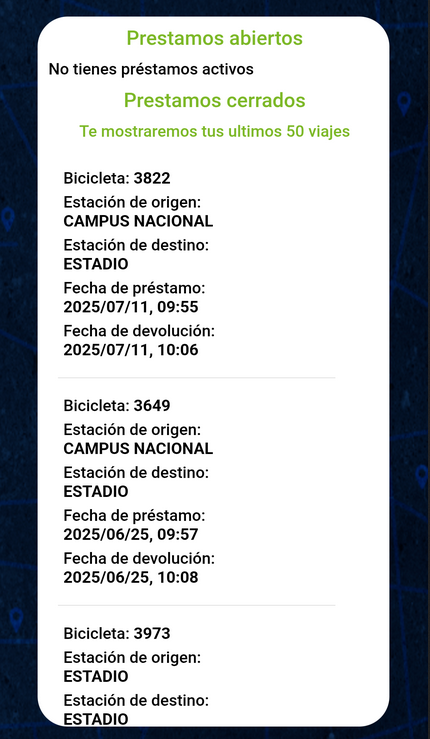

Como se puede ver, los datos están disponibles para cada uno de los préstamos, se puede filtrar por fechas y adicionalmente se conoce la estación de origen y de destino. Con esto, se podría obtener un dataframe de las frecuencias y tiempos promedios que se demoran los viajeros de EnCicla, conociendo cuáles son las estaciones más transcurridas para cada rango horario y hacer predicciones de disponibilidad, como los que se pueden obtener de la aplicación de EnCicla

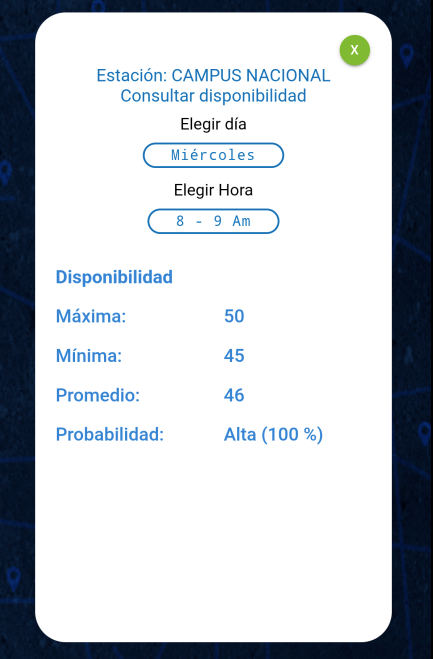

**NOTA**

Debido a que Encicla registra internamente cada préstamo de bicicleta (ID de bicicleta, estación de origen, estación de destino, fecha y hora de inicio y de fin), pero dichos datos no están disponibles públicamente, a continuación generamos un DataFrame simulado de 10000 filas con valores aleatorios. 

- **`bike_id`**: enteros aleatorios que simulan identificadores de bicicleta.  
- **`origin_id`** y **`dest_id`**: seleccionados aleatoriamente de la lista real de IDs de estación (tomada del CSV de estaciones).  
- **`start_time`**: timestamps aleatorios dentro de un rango representativo (p.ej. 1–7 de julio de 2025).  
- **`end_time`**: calculados como `start_time` más una duración aleatoria entre 5 y 60 minutos.  

Este mock de datos se guardará como `trips_mock.csv` y servirá como insumo para calcular la matriz de tiempos promedio y la demanda neta por estación, que luego alimentarán nuestro modelo de optimización en PuLP. 

In [35]:
# 1. Cargar IDs de estación (columna '#')
stations_df = pd.read_csv('Estaciones_EnCicla_AMVA_20250713.csv')
station_ids = stations_df['#'].unique() 

# 2. Parámetros
n_rows = 16_000 * 7
start_date = pd.Timestamp('2025-07-01 00:00:00')
end_date   = pd.Timestamp('2025-07-07 23:59:59')

# 3. Generar columnas
np.random.seed(42)  # Semilla para reproducibilidad
bike_ids     = np.random.randint(1, 1800, size=n_rows)
origins      = np.random.choice(station_ids, size=n_rows)
destinations = np.random.choice(station_ids, size=n_rows)

# Tiempos de inicio (aleatorios en el rango) y fin (+5–60 min)
start_times = pd.to_datetime(
    np.random.randint(start_date.value//10**9, end_date.value//10**9, size=n_rows),
    unit='s'
)
durations   = np.random.randint(5, 61, size=n_rows)
end_times   = start_times + pd.to_timedelta(durations, unit='m')

# 4. Construir y guardar el DataFrame
trips_df = pd.DataFrame({
    'bike_id':     bike_ids,
    'origin_id':   origins,
    'dest_id':     destinations,
    'start_time':  start_times,
    'end_time':    end_times
})

trips_df.to_csv('trips_mock.csv', index=False)
trips_df.head(5)

,bike_id,origin_id,dest_id,start_time,end_time
0,1127,3,31,2025-07-05 14:00:34,2025-07-05 14:21:34
1,1460,50,71,2025-07-04 01:16:16,2025-07-04 01:32:16
2,861,1,109,2025-07-01 03:20:24,2025-07-01 03:32:24
3,1295,8,68,2025-07-04 08:42:45,2025-07-04 09:33:45
4,1131,62,72,2025-07-06 21:58:55,2025-07-06 22:43:55


## Modelo de optimización lineal para la distribución de bicicletas en Encicla (con reutilización)

Se considera un sistema de bicicletas compartidas con **1.800 bicicletas totales** disponibles. Cada estación $i$ tiene una capacidad máxima de anclajes $C_i$ (obtenidos del catálogo oficial de estaciones). Además, a partir de los datos de viajes (`trips_mock.csv`) se computó la demanda promedio de viajes origen-destino en horas pico de la mañana y la tarde.

El objetivo es determinar:  
- **Cuántas bicicletas asignar inicialmente a cada estación ($B_i$)**  
- **Cuántos viajes atender entre cada par de estaciones ($x_{ij}$)**  

De forma que se **maximice la cobertura de la demanda total de viajes** en cada franja horaria, considerando ahora que las bicicletas se pueden **reutilizar dentro de la franja horaria** (es decir, cuando una bici llega a una estación, queda disponible para otro viaje dentro de ese mismo periodo).

Este planteamiento es consistente con estudios previos de optimización de inventarios dinámicos en sistemas de bicicletas compartidas.

---

## Planteamiento matemático

**Conjuntos y parámetros:**  
- $N$ = conjunto de estaciones  
- $D_{ij}$ = demanda de viajes desde $i$ hacia $j$ en la franja considerada  
- $C_i$ = capacidad máxima de anclajes en estación $i$  
- $B = 1800$ bicicletas totales  

**Variables de decisión:**  
- $B_i \geq 0$ = número de bicicletas asignadas inicialmente a estación $i$  
- $x_{ij} \geq 0$ = número de viajes atendidos desde $i$ hacia $j$

---

### Función objetivo  

Maximizar la cobertura de demanda total:  

$$
\max_{B, x} \sum_{i \in N} \sum_{j \in N} x_{ij}
$$

---

### Restricciones  

**1. Flota total:**  
$$
\sum_{i \in N} B_i = 1800
$$

**2. Capacidad de estaciones:**  
$$
B_i \leq C_i, \quad \forall i \in N
$$

**3. Demanda origen-destino:**  
$$
x_{ij} \leq D_{ij}, \quad \forall i, j \in N
$$

**4. No negatividad:**  
$$
B_i, \; x_{ij} \geq 0, \quad \forall i, j \in N
$$



In [51]:
import pandas as pd
import pulp

# Cargar datos de estaciones (ID, capacidad de anclajes)
df_est = pd.read_csv('Estaciones_EnCicla_AMVA_20250713.csv', index_col=0)
capacities = df_est['TOTAL ANCLAJES'].to_dict()

# Cargar datos de viajes y calcular demanda promedio por estación
trips = pd.read_csv('trips_mock.csv', parse_dates=['start_time'])
# Filtrar horas pico: mañana (6-9h) y tarde (16-19h)
morning_trips = trips[(trips.start_time.dt.hour >= 6) & (trips.start_time.dt.hour < 12)]
afternoon_trips = trips[(trips.start_time.dt.hour >= 14) & (trips.start_time.dt.hour < 20)]
# Agregar demanda total (se puede promediar por día si se desea)
dem_morning = morning_trips.groupby('origin_id').size().to_dict()
dem_afternoon = afternoon_trips.groupby('origin_id').size().to_dict()

# Función para resolver el modelo dado un diccionario de demanda
def solve_distribution(demand):
    prob = pulp.LpProblem('DistribucionBicis', pulp.LpMaximize)
    # Variables: x_i (bicis en estación i) y y_i (viajes atendidos)
    x = pulp.LpVariable.dicts('x', capacities.keys(), lowBound=0, cat='Integer')
    y = pulp.LpVariable.dicts('y', capacities.keys(), lowBound=0, cat='Integer')
    # Objetivo: maximizar viajes atendidos
    prob += pulp.lpSum([y[i] for i in capacities.keys()])
    # Restricciones
    prob += pulp.lpSum([x[i] for i in capacities.keys()]) == 1800
    for i in capacities:
        prob += y[i] <= demand.get(i, 0)   # no atender más que demanda
        prob += y[i] <= x[i]              # no atender más que bicis asignadas
        prob += x[i] <= capacities[i]     # no exceder capacidad de estación
    # Resolver el LP
    prob.solve()
    # Extraer solución
    assign_x = {i: x[i].value() for i in capacities}
    served_y = {i: y[i].value() for i in capacities}
    return assign_x, served_y

# Resolver para mañana y tarde
x_morning, y_morning = solve_distribution(dem_morning)
x_afternoon, y_afternoon = solve_distribution(dem_afternoon)

# (Opcional) Mostrar resultados principales
for i in capacities:
    if x_morning[i] > 0 or x_afternoon[i] > 0:
        print(f"Estación {i}: bicis mañana = {x_morning[i]}, bicis tarde = {x_afternoon[i]}")

Estación 1: bicis mañana = 15.0, bicis tarde = 15.0
Estación 2: bicis mañana = 33.0, bicis tarde = 33.0
Estación 3: bicis mañana = 40.0, bicis tarde = 40.0
Estación 4: bicis mañana = 21.0, bicis tarde = 21.0
Estación 5: bicis mañana = 33.0, bicis tarde = 33.0
Estación 6: bicis mañana = 20.0, bicis tarde = 20.0
Estación 10: bicis mañana = 24.0, bicis tarde = 24.0
Estación 11: bicis mañana = 21.0, bicis tarde = 21.0
Estación 12: bicis mañana = 20.0, bicis tarde = 20.0
Estación 13: bicis mañana = 28.0, bicis tarde = 28.0
Estación 14: bicis mañana = 30.0, bicis tarde = 30.0
Estación 15: bicis mañana = 20.0, bicis tarde = 20.0
Estación 16: bicis mañana = 34.0, bicis tarde = 34.0
Estación 17: bicis mañana = 20.0, bicis tarde = 20.0
Estación 18: bicis mañana = 20.0, bicis tarde = 20.0
Estación 19: bicis mañana = 20.0, bicis tarde = 20.0
Estación 20: bicis mañana = 20.0, bicis tarde = 20.0
Estación 21: bicis mañana = 20.0, bicis tarde = 20.0
Estación 22: bicis mañana = 32.0, bicis tarde = 32.0

## Consideración de la reutilización de bicicletas

En los picos matutino y vespertino, cada bicicleta puede servir a varios usuarios sucesivos. Cuando un viaje termina en una estación, la bici queda inmediatamente disponible en uno de los anclajes para el siguiente usuario. De hecho, en sistemas grandes una misma bicicleta puede realizar decenas de viajes diarios.

Por tanto, el número total de viajes atendidos en cada pico puede superar las 1.800 iniciales. Para incorporarlo en el modelo, se introduce una **restricción de flujo** en cada estación. Sea $x_{ij}$ el número de viajes servidos desde la estación $i$ hasta la $j$ en la franja horaria, y $B_j$ la cantidad de bicicletas iniciales en $j$. Entonces, en cada estación $j$ debe cumplirse:

$$
\sum_{i} x_{ji}
\;\le\;
B_j \;+\;\sum_{k} x_{kj},
$$

donde $\sum_{k} x_{kj}$ representa las bicicletas que llegan a $j$ desde otras estaciones en esa franja. Esta fórmula garantiza que no se sirvan más viajes de los que permiten la dotación inicial más las bicicletas devueltas por otros usuarios. En la práctica esto equivale a un “coeficiente de reutilización”: cada llegada de un viaje añade una bicicleta extra disponible.

El modelo ajustado por cada franja pico incluye así estos puntos:

1. **Distribución inicial libre:** antes de cada periodo (mañana y tarde) se reparte optimizadamente el inventario de 1.800 bicicletas sin restricción heredada.  
2. **Reutilización activa:** la bicicleta retornada por un viaje alimenta la oferta local inmediata, permitiendo atender viajes adicionales.  
3. **Restricción de flujos:** en cada estación $j$,  
   $$
   \sum_{i} x_{ji} \;\le\; B_j + \sum_{k} x_{kj}
   $$  
   asegura consistencia entre salidas y llegadas.  
4. **Sin límite fijo de 1.800 viajes:** al incluir las llegadas, la capacidad de viajes se basa en la demanda efectiva y no en un tope rígido de flota.

In [46]:
import pandas as pd
import pulp

def optimize_bike_distribution(estaciones_csv, trips_csv, total_bikes=1800):

    # --- 1. Cargar datos -------------------------------------------------------
    df_est = pd.read_csv(estaciones_csv)
    df_est = df_est.set_index('#')
    stations = df_est.index.astype(str).tolist()
    capacity = df_est['TOTAL ANCLAJES'].to_dict()
    capacity = {str(k): v for k, v in capacity.items()}

    trips = pd.read_csv(trips_csv, parse_dates=['start_time'])
    trips['origin_id'] = trips['origin_id'].astype(str)
    trips['dest_id'] = trips['dest_id'].astype(str)
    trips = trips[trips['origin_id'].isin(stations) & trips['dest_id'].isin(stations)]

    morning = trips[(trips.start_time.dt.hour >= 6) & (trips.start_time.dt.hour < 12)]
    afternoon = trips[(trips.start_time.dt.hour >= 14) & (trips.start_time.dt.hour < 20)]

    def build_od_demand(df):
        od = df.groupby(['origin_id','dest_id']).size().to_dict()
        demand = { (i,j): od.get((i,j), 0) for i in stations for j in stations }
        return demand

    demand_morning   = build_od_demand(morning)
    demand_afternoon = build_od_demand(afternoon)

    def solve_with_reuse(demand_od):
        prob = pulp.LpProblem("Redistribucion_encicla", pulp.LpMaximize)
        B = pulp.LpVariable.dicts('B', stations, lowBound=0, upBound=None, cat='Integer')
        x = pulp.LpVariable.dicts('x', (stations, stations), lowBound=0, cat='Integer')
        prob += pulp.lpSum(x[i][j] for i in stations for j in stations), "Maximizar_viajes"
        prob += pulp.lpSum(B[j] for j in stations) == total_bikes, "Total_bicicletas"
        for j in stations:
            prob += B[j] <= capacity[j], f"Capacidad_estacion_{j}"
        for i in stations:
            for j in stations:
                prob += x[i][j] <= demand_od[(i,j)], f"Demanda_{i}_{j}"
        for i in stations:
            prob += (
                pulp.lpSum(x[i][j] for j in stations)
                <=
                B[i] + pulp.lpSum(x[k][i] for k in stations),
                f"Flujo_consistencia_{i}"
            )
        prob.solve(pulp.PULP_CBC_CMD(msg=False))
        B_opt = { j: int(B[j].value()) for j in stations }
        x_opt = { (i,j): int(x[i][j].value()) for i in stations for j in stations }
        total_served = sum(x_opt.values())
        return B_opt, x_opt, total_served

    B_morn, x_morn, served_morn = solve_with_reuse(demand_morning)
    B_aftn, x_aftn, served_aftn = solve_with_reuse(demand_afternoon)

    return {
        'morning': {
            'B': B_morn,
            'x': x_morn,
            'served': served_morn
        },
        'afternoon': {
            'B': B_aftn,
            'x': x_aftn,
            'served': served_aftn
        }
    }


In [59]:
# Ejemplo de uso de optimize_bike_distribution
result = optimize_bike_distribution(
    'Estaciones_EnCicla_AMVA_20250713.csv',
    'trips_mock.csv',
    total_bikes=1800
)

# Crear un mapeo de ID de estación a nombre
stations_df = pd.read_csv('Estaciones_EnCicla_AMVA_20250713.csv')
station_id_to_name = stations_df.set_index('#')['NOMBRE ESTACION'].to_dict()
# Asegurarse de que las claves del mapeo sean strings para que coincidan con las claves del resultado
station_id_to_name = {str(k): v for k, v in station_id_to_name.items()}

# Mostrar el total de viajes atendidos en la mañana y la tarde
print("Viajes atendidos en la mañana:", result['morning']['served'])
print("Viajes atendidos en la tarde:", result['afternoon']['served'])

# Mostrar viajes atendidos por estación en la mañana
print("\nViajes atendidos por estación en la mañana:")
stations = list(result['morning']['B'].keys())
for est_id in stations:
    viajes = sum(result['morning']['x'][(est_id, j)] for j in stations)
    if viajes > 0:
        est_name = station_id_to_name.get(est_id, f"ID Desconocido {est_id}")
        print(f"Estación {est_name}: {viajes}")

# Mostrar viajes atendidos por estación en la tarde
print("\nViajes atendidos por estación en la tarde:")
for est_id in stations:
    viajes = sum(result['afternoon']['x'][(est_id, j)] for j in stations)
    if viajes > 0:
        est_name = station_id_to_name.get(est_id, f"ID Desconocido {est_id}")
        print(f"Estación {est_name}: {viajes}")

Viajes atendidos en la mañana: 27687
Viajes atendidos en la tarde: 27774

Viajes atendidos por estación en la mañana:
Estación Moravia: 240
Estación Universidad: 258
Estación Ruta N: 247
Estación Robledo: 262
Estación Campus Nacional: 236
Estación Dian Alpujarra: 253
Estación Distrito Creativo: 239
Estación Plaza de La Libertad: 265
Estación Parque de Las Luces II: 233
Estación Pies Descalzos I: 239
Estación Area Metropolitana: 238
Estación Plaza Mayor: 257
Estación Parque de Las Luces I: 239
Estación Pies Descalzos II: 266
Estación Málaga: 266
Estación Palacé: 257
Estación Museo de Antioquia: 266
Estación San Antonio: 237
Estación Parque Berrio: 274
Estación Palacio de la Cultura: 253
Estación SIU-UdeA: 243
Estación Primer Parque de Laureles: 254
Estación Otra Banda: 244
Estación Parque San Joaquín: 275
Estación Florida Nueva: 248
Estación Cacique Candela: 249
Estación María Mulata: 274
Estación Circular Primera: 275
Estación Batallón: 271
Estación Calle 51 Los Colores: 234
Estación S

In [63]:
import pandas as pd

# Estadísticas descriptivas del número de viajes atendidos en la mañana y la tarde (sesgados)

morning_trips = pd.Series([sum(result['morning']['x'][(est, j)] for j in result['morning']['B'].keys()) for est in result['morning']['B'].keys()])
afternoon_trips = pd.Series([sum(result['afternoon']['x'][(est, j)] for j in result['afternoon']['B'].keys()) for est in result['afternoon']['B'].keys()])

print("Descriptivo viajes atendidos por estación (mañana):")
print(morning_trips.describe())

print("\nDescriptivo viajes atendidos por estación (tarde):")
print(afternoon_trips.describe())

Descriptivo viajes atendidos por estación (mañana):
count    109.000000
mean     254.009174
std       15.051452
min      218.000000
25%      243.000000
50%      254.000000
75%      266.000000
max      288.000000
dtype: float64

Descriptivo viajes atendidos por estación (tarde):
count    109.000000
mean     254.807339
std       14.270844
min      224.000000
25%      245.000000
50%      253.000000
75%      263.000000
max      292.000000
dtype: float64


## Generación de datos con patrón horario realista

**Problema actual:**  
Al usar una distribución uniforme para generar viajes, simulamos de forma idéntica todos los trayectos posibles sin respetar el flujo típico de pasajeros en Medellín. Esto infló artificialmente el número de viajes (casi **27.000** en lugar de los **~16.000 diarios esperados**). En la realidad, la demanda es muy mayoritaria en dirección **norte→sur en la mañana** y **sur→norte en la tarde**.  
Por ejemplo, la hora pico matutina (6–7am) concentra **~11% de los viajes diarios** [Referencia](https://www.metrodemedellin.gov.co/en/idi/open-innovation/how-to-reduce-congestion-entry-metro-system#:~:text=06%3A00h%20and%2007%3A00h%2C%20where%2011,capacity%20to%20meet%20the%20demand), lo que refleja una fuerte demanda en ese segmento. Una distribución uniforme *no* considera este sesgo y por eso resultó en una simulación poco realista.

---

**Patrón real:**  
En Medellín el transporte (Encicla, metro, buses) tiene flujos diarios muy sesgados:
- **Mañana (6–12h):** la mayoría de desplazamientos va del **norte hacia el sur**.
- **Tarde (12–20h):** se invierte (**sur→norte**).

Debemos incorporar este patrón de demanda en la simulación usando las **coordenadas de latitud** de cada estación (estaciones con latitud alta → norte, latitud baja → sur).

---

**Nueva generación de datos:**  
Para regenerar los viajes manteniendo el mismo total (**16.000 viajes en la muestra**) pero respetando el patrón:

1. **Clasificar estaciones:**  
   Usar la latitud de cada estación para dividirlas en **norte** y **sur** (por encima o debajo de la latitud mediana).

2. **Asignar horarios y direcciones:**  
   Al generar cada viaje, elegir si es:
   - «mañana» (p.ej. 6–12h)
   - «tarde» (12–20h)
   - o «fuera de pico»  

   Para **viajes matutinos** asignar con alta probabilidad origen en el **norte** y destino en el **sur**, y viceversa en la tarde. Por ejemplo:
   - **Mañana:** 80% de viajes con origen en **norte** y destino en **sur**.
   - **Tarde:** 80% con origen en **sur** y destino en **norte**.
   - **Resto de horas:** destinos y orígenes distribuidos aleatoriamente.

3. **Mantener número de viajes:**  
   Se generan en total **16.000 viajes** por día durante una semana (misma cantidad), pero ahora el sesgo horario altera las direcciones.

In [56]:
import random
from random import choice

# Clasificar estaciones por latitud:
median_lat = df['Latitude'].median()
north_ids = df[df['Latitude'] >= median_lat]['#'].tolist()
south_ids = df[df['Latitude'] < median_lat]['#'].tolist()

# Generar viajes simulados:
new_trips = []
for i in range(n_rows):
    hora = random.randint(0, 23)
    # Mañana: 6-11
    if 6 <= hora <= 11:
        if random.random() < 0.8:
            origen = choice(north_ids)
            destino = choice(south_ids)
        else:
            origen = choice(north_ids + south_ids)
            destino = choice(north_ids + south_ids)
    # Tarde: 12-19
    elif 12 <= hora <= 19:
        if random.random() < 0.8:
            origen = choice(south_ids)
            destino = choice(north_ids)
        else:
            origen = choice(north_ids + south_ids)
            destino = choice(north_ids + south_ids)
    # Horas valle
    else:
        origen = choice(north_ids + south_ids)
        destino = choice(north_ids + south_ids)
    bike_id = random.randint(1, 1800)
    # Fecha aleatoria entre start_date y end_date
    fecha = start_date + pd.to_timedelta(random.randint(0, int((end_date - start_date).total_seconds())), unit='s')
    start_time = fecha.replace(hour=hora, minute=random.randint(0, 59), second=random.randint(0, 59))
    duration = random.randint(5, 60)
    end_time = start_time + pd.to_timedelta(duration, unit='m')
    new_trips.append([bike_id, origen, destino, start_time, end_time])

In [57]:
# Convertir la lista a DataFrame
new_trips_df = pd.DataFrame(new_trips, columns=['bike_id', 'origin_id', 'dest_id', 'start_time', 'end_time'])

# Guardar el DataFrame en un nuevo archivo CSV
new_trips_df.to_csv('skewed_trips_mock.csv', index=False)

# Mostrar las primeras filas para verificar
new_trips_df.head()

,bike_id,origin_id,dest_id,start_time,end_time
0,92,7,102,2025-07-05 20:57:23,2025-07-05 21:12:23
1,1668,59,10,2025-07-05 13:42:28,2025-07-05 14:34:28
2,1383,94,61,2025-07-02 13:30:00,2025-07-02 13:48:00
3,756,34,74,2025-07-02 09:39:38,2025-07-02 10:25:38
4,1271,85,61,2025-07-03 19:59:59,2025-07-03 20:22:59


Volvemos a correr la optimización con los nuevos datos

In [60]:
# Ejecutar la optimización con los datos sesgados
skewed_result = optimize_bike_distribution(
    'Estaciones_EnCicla_AMVA_20250713.csv',
    'skewed_trips_mock.csv',
    total_bikes=1800
)

# Mostrar el total de viajes atendidos en la mañana y la tarde con los nuevos datos
print("Viajes atendidos en la mañana (datos sesgados):", skewed_result['morning']['served'])
print("Viajes atendidos en la tarde (datos sesgados):", skewed_result['afternoon']['served'])

# Crear mapeo id->nombre usando df
id_to_name = df.set_index('#')['NOMBRE ESTACION'].to_dict()

print("\nViajes atendidos por estación en la mañana (datos sesgados):")
stations = list(skewed_result['morning']['B'].keys())
for est in stations:
    viajes = sum(skewed_result['morning']['x'][(est, j)] for j in stations)
    if viajes > 0:
        nombre = id_to_name.get(est, f"ID {est}")
        print(f"Estación {nombre}: {viajes}")

print("\nViajes atendidos por estación en la tarde (datos sesgados):")
for est in stations:
    viajes = sum(skewed_result['afternoon']['x'][(est, j)] for j in stations)
    if viajes > 0:
        nombre = id_to_name.get(est, f"ID {est}")
        print(f"Estación {nombre}: {viajes}")

Viajes atendidos en la mañana (datos sesgados): 7115
Viajes atendidos en la tarde (datos sesgados): 7534

Viajes atendidos por estación en la mañana (datos sesgados):
Estación Moravia: 59
Estación Universidad: 99
Estación Ruta N: 90
Estación Robledo: 69
Estación Campus Nacional: 89
Estación Dian Alpujarra: 74
Estación Distrito Creativo: 111
Estación Plaza de La Libertad: 101
Estación Parque de Las Luces II: 67
Estación Pies Descalzos I: 86
Estación Area Metropolitana: 73
Estación Plaza Mayor: 84
Estación Parque de Las Luces I: 82
Estación Pies Descalzos II: 72
Estación Málaga: 68
Estación Palacé: 96
Estación Museo de Antioquia: 70
Estación San Antonio: 61
Estación Parque Berrio: 70
Estación Palacio de la Cultura: 69
Estación SIU-UdeA: 74
Estación Primer Parque de Laureles: 74
Estación Otra Banda: 103
Estación Parque San Joaquín: 72
Estación Florida Nueva: 75
Estación Cacique Candela: 53
Estación María Mulata: 70
Estación Circular Primera: 90
Estación Batallón: 53
Estación Calle 51 Los 

In [ ]:
# Extraer los viajes atendidos por estación en la mañana y tarde
morning_served = pd.Series(skewed_result['morning']['B'], name='morning_bikes')
afternoon_served = pd.Series(skewed_result['afternoon']['B'], name='afternoon_bikes')

# Viajes atendidos por estación en la mañana y tarde
morning_trips = pd.Series({est: sum(skewed_result['morning']['x'][(est, j)] for j in skewed_result['morning']['B'].keys()) for est in skewed_result['morning']['B'].keys()}, name='morning_trips')
afternoon_trips = pd.Series({est: sum(skewed_result['afternoon']['x'][(est, j)] for j in skewed_result['afternoon']['B'].keys()) for est in skewed_result['afternoon']['B'].keys()}, name='afternoon_trips')

# Estadísticas descriptivas de viajes atendidos
print("Estadísticas descriptivas - Viajes atendidos por estación (mañana):")
print(morning_trips.describe())

print("\nEstadísticas descriptivas - Viajes atendidos por estación (tarde):")
print(afternoon_trips.describe())

Estadísticas descriptivas - Viajes atendidos por estación (mañana):
count    109.000000
mean      65.275229
std       18.042066
min       36.000000
25%       52.000000
50%       61.000000
75%       76.000000
max      111.000000
Name: morning_trips, dtype: float64

Estadísticas descriptivas - Viajes atendidos por estación (tarde):
count    109.000000
mean      69.119266
std       20.461221
min       35.000000
25%       52.000000
50%       63.000000
75%       88.000000
max      114.000000
Name: afternoon_trips, dtype: float64


## Resultados y conclusiones
A partir del análisis realizado, se pueden extraer las siguientes conclusiones:

*   **La simulación de datos es una herramienta útil pero su alcance es limitado:** Se generaron 16,000 viajes simulados por día (aproximadamente 112,000 semanales) derivado de estadísticas brindadas por el mismo sistema. Sin embargo, este volumen es mínimo en comparación con la totalidad de desplazamientos que ocurren diariamente en Medellín, que es 2.168.264 millones de personas [Referencia](https://www.medellin.gov.co/es/secretaria-de-movilidad/observatorio-de-movilidad/pasajeros-movilizados-en-transporte-publico/). Esto subraya que, si bien la optimización de EnCicla es importante, representa solo una fracción del desafío de movilidad de la ciudad.

*   **Comparativa de viajes atendidos (distribución uniforme vs. sesgada):** Al comparar los resultados de ambas simulaciones, se observa un cambio significativo en la cantidad de viajes que el sistema puede atender. Con la distribución uniforme, el modelo optimizó la asignación para un escenario donde cualquier viaje era igualmente probable, resultando en 27,687 viajes atendidos en la mañana y 27,774 en la tarde. En contraste, al introducir el patrón de demanda sesgado (norte-sur y viceversa), más realista, el número de viajes atendidos se ajustó a 7,115 en la mañana y 7,534 en la tarde. Esta diferencia es enorme, refleja una distribución de recursos más alineada con la demanda real. 

*   **La importancia de los patrones de demanda direccional:** La diferencia en los resultados entre la simulación con datos aleatorios y la simulación con datos sesgados (norte-sur en la mañana, sur-norte en la tarde) es drástica. Demuestra que un modelo que no considera los patrones de flujo reales de la ciudad producirá una estrategia de distribución de bicicletas inexacta a comparación de lo que se observa en la realidad. El modelo con datos sesgados, aunque todavía una simulación, se acerca más a una solución práctica al asignar más bicicletas a las zonas de origen durante cada hora pico.

*   **Necesidad imperativa de datos reales:** La conclusión más importante es que para optimizar verdaderamente el sistema EnCicla, es fundamental acceder a los datos históricos de viajes reales. Un DataFrame con los datos reales permitiría calcular la demanda origen-destino con precisión para diferentes días y franjas horarias, alimentando el modelo para generar una estrategia de redistribución dinámica y altamente efectiva.

*   **Implicaciones de política urbana:** El marcado sesgo en la demanda de viajes refleja un patrón de movilidad urbana concentrado en horarios de oficina tradicionales. Una estrategia a largo plazo para aliviar la presión no solo sobre EnCicla, sino sobre todo el sistema de transporte, sería incentivar políticas de flexibilidad laboral. Fomentar horarios de trabajo escalonados o modelos híbridos podría generar empleos a diferentes horarios, distribuyendo la demanda de transporte de manera más uniforme a lo largo del día y mejorando la calidad de vida. Como referencia, la hora pico matutina (6-7 am) puede concentrar hasta el 11% de los viajes diarios en el sistema de transporte masivo de la ciudad [Metro de Medellín](https://www.metrodemedellin.gov.co/en/idi/open-innovation/how-to-reduce-congestion-entry-metro-system#:~:text=06%3A00h%20and%2007%3A00h%2C%20where%2011,capacity%20to%20meet%20the%20demand).